# Few Shot Node Classification w/ Graph Attention Network (GAT) Architecture

## I. Initial dataset prep

### Download and import libraries for graph learning

In [99]:
#!pip install dgl
#!pip install torch

In [100]:
import dgl
import torch
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn import GATConv
from dgl.nn import GraphConv

### Download the dataset

In [101]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [102]:
# Let's examine the number of distinct node classes
print(torch.unique(g.ndata['label']))
print(torch.bincount(g.ndata['label']))

tensor([0, 1, 2, 3, 4, 5, 6])
tensor([351, 217, 418, 818, 426, 298, 180])


## II. Model prep

### Create a GAT model

In [103]:
class GAT(nn.Module):
    """
    Graph Attention Network model with two layers.

    GAT has weight matrices with a non-linearity layer in between. It
    has attention heads that weight the messages between nodes.
    We do not need a non-linearity after the final layer, as the loss
    function accepts logits.
    """
    def __init__(self, in_feats, h_feats, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, h_feats, num_heads = 2)
        self.conv2 = GATConv(h_feats * 2, num_classes, num_heads = 1)

    def forward(self, g, in_feat):     
        h = self.conv1(g, in_feat)
        h = h.view(-1, h.size(1) * h.size(2))
        h = F.elu(h)
        h = self.conv2(g, h)
        h = h.squeeze()
        
        return h

### Helper function for creating tasks from nodes

In [104]:
# Sample num_shots nodes from a given class
def gen_task(g, label_num, num_shots):
    indices = torch.flatten(torch.nonzero(g.ndata['label'] == label_num))
    num_indices = len(indices)

    train_shots = np.random.choice(num_indices, num_shots)
    test_nodes = np.delete(indices, train_shots)
    train_shots = indices[train_shots]

    return train_shots, test_nodes

### Create the 1, 2, and 3-shot test tasks for the test classes

In [105]:
test_classes = (1, 5)
num_runs = 50

one_shot_runs = []
two_shot_runs = []
three_shot_runs = []

for j in range(num_runs):
    # Generate the 1 shot tasks
    one_shot_train_list = []
    one_shot_test_list = []
    for i, class_lab in enumerate(test_classes): 
        cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                    num_shots = 1)
        one_shot_train_list.append(cur_train_shots)
        one_shot_test_list.append(cur_test_nodes)

    # Generate the 2 shot tasks
    two_shot_train_list = []
    two_shot_test_list = []
    for i, class_lab in enumerate(test_classes): 
        cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                    num_shots = 2)
        two_shot_train_list.append(cur_train_shots)
        two_shot_test_list.append(cur_test_nodes)

    # Generate the 3 shot tasks
    three_shot_train_list = []
    three_shot_test_list = []
    for i, class_lab in enumerate(test_classes): 
        cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                    num_shots = 3)
        three_shot_train_list.append(cur_train_shots)
        three_shot_test_list.append(cur_test_nodes)

    # Append to the runs
    one_shot_runs.append((one_shot_train_list, one_shot_test_list))
    two_shot_runs.append((two_shot_train_list, two_shot_test_list))
    three_shot_runs.append((three_shot_train_list, three_shot_test_list))

## III. Traditional graph learning

### Create a training loop for traditional graph learning

In [106]:
# Provided test set query classes 
def training_loop(num_shots, num_epochs, classes, num_ways, 
                  train_shots, test_nodes):  

    if len(classes) != num_ways:
      print("Number of classes provided does not equal desired number"
            "of classes for classification task")
      raise ValueError

    model = GAT(g.ndata['feat'].shape[1], 64, 2)
  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    features = torch.clone(g.ndata['feat'])
    labels = torch.clone(g.ndata['label'])

    # Relabel the classes, obtain training shots
    for i, class_lab in enumerate(classes): 
      labels[g.ndata['label']==class_lab] = i

    # Save accuracy values
    best_val_acc = 0
    best_test_acc = 0
    train_accs = []
    test_accs = []

    # Get all training shots and query examples
    all_shots = np.concatenate(train_shots)
    all_query = np.concatenate(test_nodes)

    for epoch in range(num_epochs):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss for the given shots 
        loss = F.cross_entropy(logits[all_shots], labels[all_shots])

        # Compute accuracy on training/validation/test
        train_acc = (pred[all_shots] == labels[all_shots]).float().mean()
        test_acc = (pred[all_query] == labels[all_query]).float().mean()

        # Save the training and test accs
        train_accs.append(train_acc.item())
        test_accs.append(test_acc.item())

        # Save the best validation accuracy and the corresponding test accuracy
        if best_test_acc < test_acc:
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return train_accs, test_accs, best_test_acc

### Input hyperparameters, run traditional graph learning for a 2-way, 1-shot task

In [107]:
# Input parameters here
num_shots = 1
num_ways = 2
num_training_epochs = 100

In [108]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

all_train_accs = []
all_test_accs = []
best_test_accs = []
terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = training_loop(num_shots, num_training_epochs, 
                                                                test_classes, num_ways, 
                                                                train_shots = one_shot_runs[i][0], 
                                                                test_nodes = one_shot_runs[i][1])
    
    all_train_accs.append(cur_train_accs)
    all_test_accs.append(cur_test_accs)
    best_test_accs.append(cur_best_acc)
    terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 1-shot task

/tmp/ipykernel_31386/3806274899.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


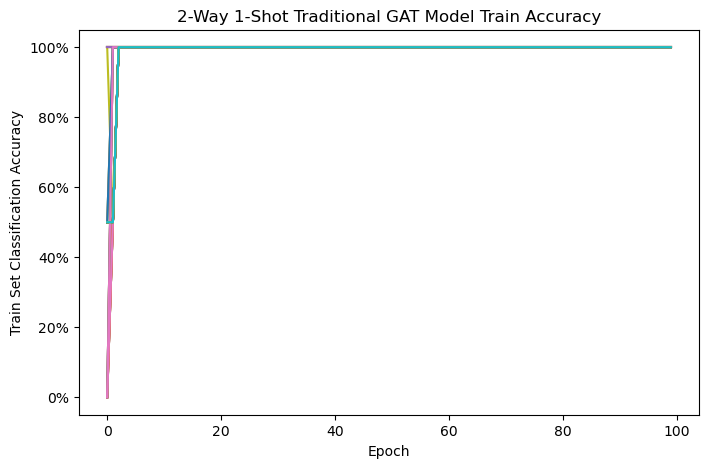

In [109]:
# Plot evolution of training accuracy
plt.figure(figsize=(8,5))
for lst in all_train_accs:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional GAT Model Train Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Train Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/343192453.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


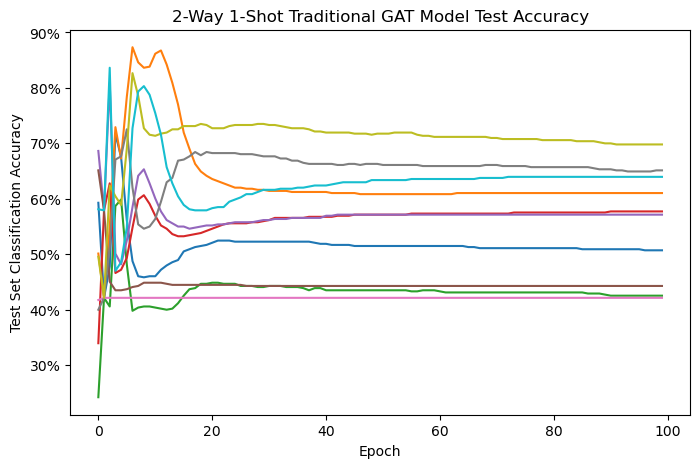

In [110]:
# Plot evolution of test accuracy 
plt.figure(figsize=(8,5))
for lst in all_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/1129041303.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.6158136355876922, 13.23, 'Mean: 71.6%')

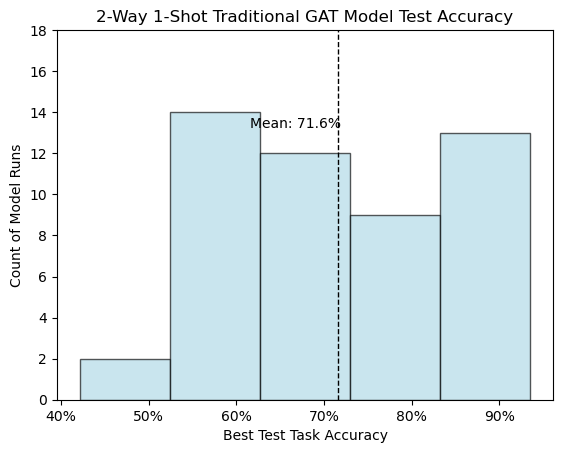

In [111]:
# Plot histogram of best accuracy achieved with mean
best_test_accs = np.array(best_test_accs)

result = plt.hist(best_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(best_test_accs.mean()*0.86, max_ylim*0.9, 
         'Mean: {:.1%}'.format(best_test_accs.mean()))

/tmp/ipykernel_31386/2726054464.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.4688545821905136, 19.845000000000002, 'Mean: 57.2%')

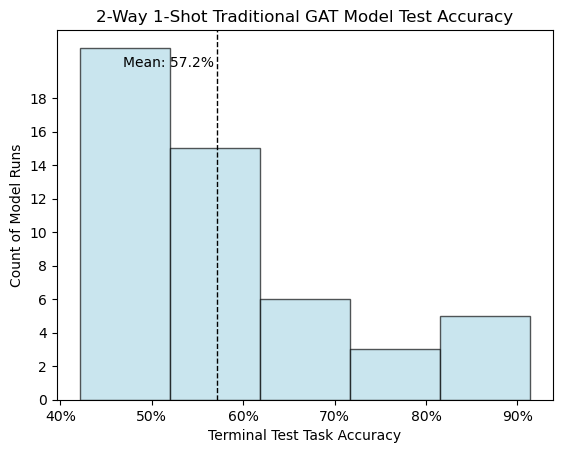

In [112]:
# Plot histogram of terminal accuracy achieved with mean
terminal_test_accs = np.array(terminal_test_accs)

result = plt.hist(terminal_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(terminal_test_accs.mean()*0.82, max_ylim*0.9, 
         'Mean: {:.1%}'.format(terminal_test_accs.mean()))

In [113]:
print('Best Accs Standard Dev: {}'.format(np.std(best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(terminal_test_accs)))

Best Accs Standard Dev: 0.1334778070449829
Terminal Accs Standard Dev: 0.1369949965950188


### Input hyperparameters, run traditional graph learning for a 2-way, 2-shot task

In [114]:
# Input parameters here
num_shots = 2
num_ways = 2
num_training_epochs = 100

In [115]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

all_train_accs = []
all_test_accs = []
best_test_accs = []
terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = training_loop(num_shots, num_training_epochs, 
                                                                test_classes, num_ways, 
                                                                train_shots = two_shot_runs[i][0], 
                                                                test_nodes = two_shot_runs[i][1])
    all_train_accs.append(cur_train_accs)
    all_test_accs.append(cur_test_accs)
    best_test_accs.append(cur_best_acc)
    terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 2-shot task

/tmp/ipykernel_31386/3806274899.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


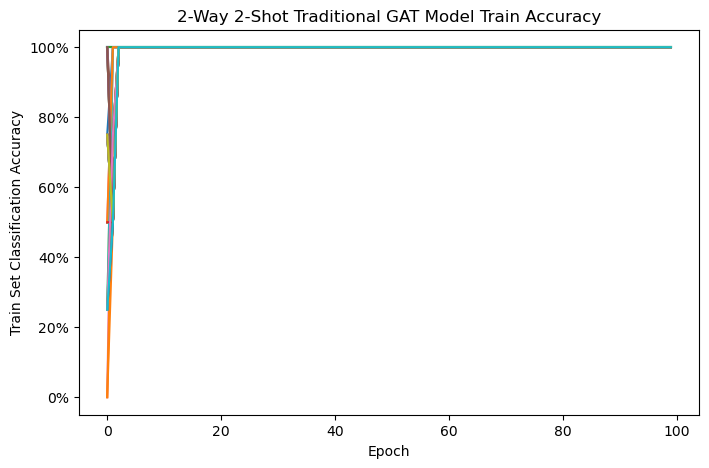

In [116]:
# Plot evolution of training accuracy
plt.figure(figsize=(8,5))
for lst in all_train_accs:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional GAT Model Train Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Train Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/343192453.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


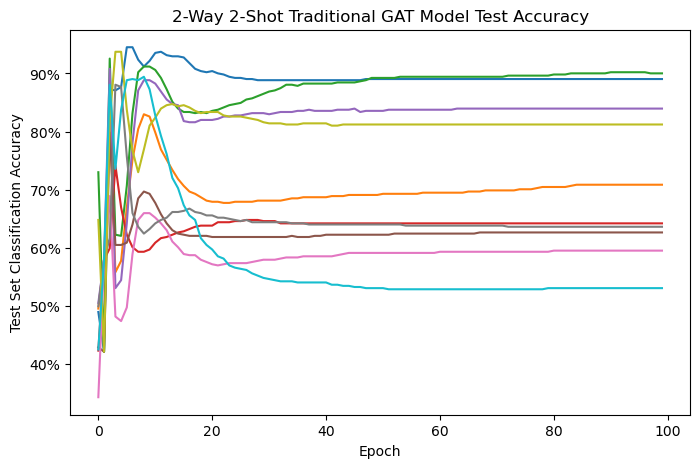

In [117]:
# Plot evolution of test accuracy 
plt.figure(figsize=(8,5))
for lst in all_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/1129041303.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.701093555688858, 21.735, 'Mean: 81.5%')

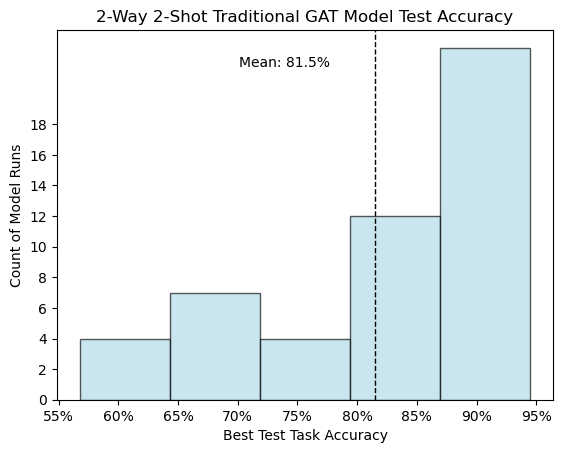

In [118]:
# Plot histogram of best accuracy achieved with mean
best_test_accs = np.array(best_test_accs)

result = plt.hist(best_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(best_test_accs.mean()*0.86, max_ylim*0.9, 
         'Mean: {:.1%}'.format(best_test_accs.mean()))

/tmp/ipykernel_31386/2726054464.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.5283624267101288, 11.34, 'Mean: 64.4%')

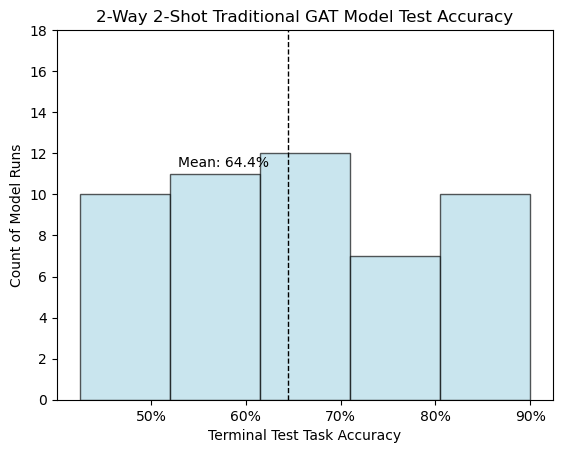

In [119]:
# Plot histogram of terminal accuracy achieved with mean
terminal_test_accs = np.array(terminal_test_accs)

result = plt.hist(terminal_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(terminal_test_accs.mean()*0.82, max_ylim*0.9, 
         'Mean: {:.1%}'.format(terminal_test_accs.mean()))

In [120]:
print('Best Accs Standard Dev: {}'.format(np.std(best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(terminal_test_accs)))

Best Accs Standard Dev: 0.10404489934444427
Terminal Accs Standard Dev: 0.13681387692450442


### Input hyperparameters, run traditional graph learning for a 2-way, 3-shot task

In [121]:
# Input parameters here
num_shots = 3
num_ways = 2
num_training_epochs = 100

In [122]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

all_train_accs = []
all_test_accs = []
best_test_accs = []
terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = training_loop(num_shots, num_training_epochs, 
                                                                test_classes, num_ways, 
                                                                train_shots = three_shot_runs[i][0], 
                                                                test_nodes = three_shot_runs[i][1])
    all_train_accs.append(cur_train_accs)
    all_test_accs.append(cur_test_accs)
    best_test_accs.append(cur_best_acc)
    terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 3-shot task

/tmp/ipykernel_31386/3806274899.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


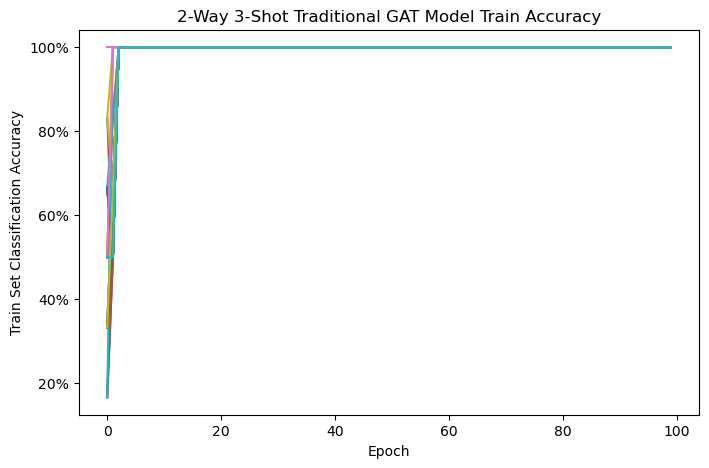

In [123]:
# Plot evolution of training accuracy
plt.figure(figsize=(8,5))
for lst in all_train_accs:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional GAT Model Train Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Train Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/343192453.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


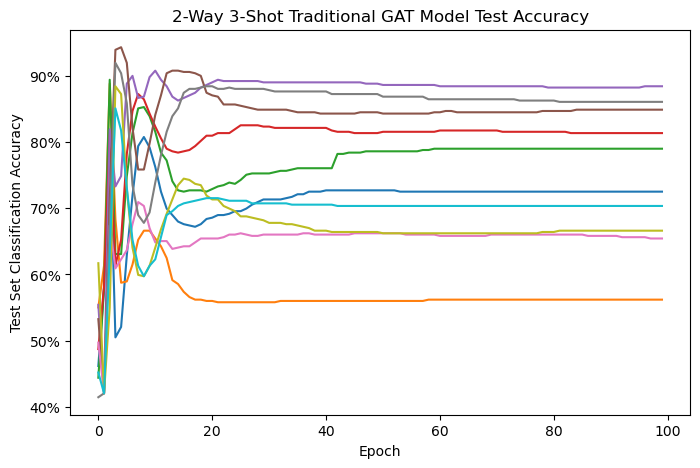

In [124]:
# Plot evolution of test accuracy 
plt.figure(figsize=(8,5))
for lst in all_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/25578467.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.7526439714431763, 28.35, 'Mean: 86.5%')

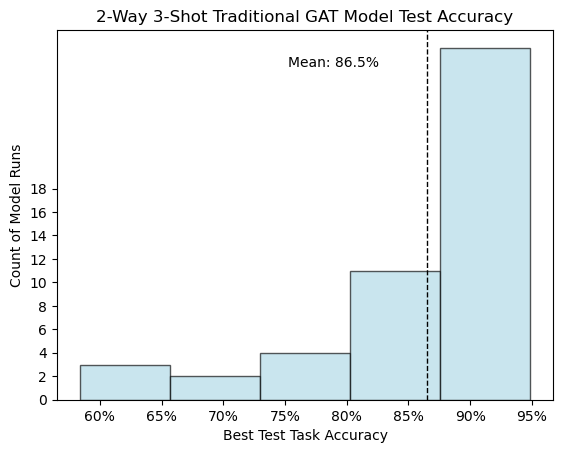

In [125]:
# Plot histogram of best accuracy achieved with mean
best_test_accs = np.array(best_test_accs)

result = plt.hist(best_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(best_test_accs.mean()*0.87, max_ylim*0.9, 
         'Mean: {:.1%}'.format(best_test_accs.mean()))

Text(0.6383182724118233, 13.23, 'Mean: 75.1%')

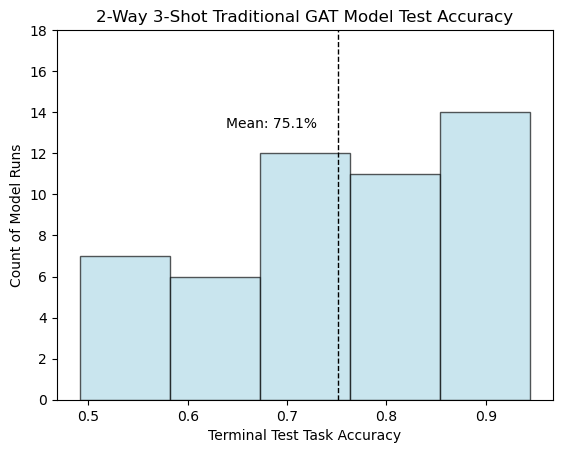

In [126]:
# Plot histogram of terminal accuracy achieved with mean
terminal_test_accs = np.array(terminal_test_accs)

result = plt.hist(terminal_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional GAT Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(terminal_test_accs.mean()*0.85, max_ylim*0.9, 
         'Mean: {:.1%}'.format(terminal_test_accs.mean()))

In [127]:
print('Best Accs Standard Dev: {}'.format(np.std(best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(terminal_test_accs)))

Best Accs Standard Dev: 0.08777999877929688
Terminal Accs Standard Dev: 0.12423809289440281


## IV. MAML with graph learning

### Create the MAML inner loop

In [128]:
def maml_inner_training_loop(outer_model, outer_optimizer, 
                             num_shots, num_epochs, classes):
      
    # Reinitialize the inner model parameters from the outer model
    inner_model = GAT(g.ndata['feat'].shape[1], 64, num_ways)

    inner_model.conv1.bias = torch.nn.Parameter(torch.clone(outer_model.conv1.bias))
    inner_model.conv2.bias = torch.nn.Parameter(torch.clone(outer_model.conv2.bias))
    inner_model.conv1.attn_l = torch.nn.Parameter(torch.clone(outer_model.conv1.attn_l))
    inner_model.conv2.attn_l = torch.nn.Parameter(torch.clone(outer_model.conv2.attn_l))
    inner_model.conv1.attn_r = torch.nn.Parameter(torch.clone(outer_model.conv1.attn_r))
    inner_model.conv2.attn_r = torch.nn.Parameter(torch.clone(outer_model.conv2.attn_r))

    inner_optimizer = torch.optim.Adam(inner_model.parameters(), lr=0.01)
    inner_features = torch.clone(g.ndata['feat'])
    inner_labels = torch.clone(g.ndata['label'])

    # Relabel the classes, obtain training shots
    inner_train_shots = []
    inner_test_nodes = []
    for i, class_lab in enumerate(classes): 
      inner_labels[g.ndata['label']==class_lab] = i
      cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                 num_shots = num_shots)
      inner_train_shots.append(cur_train_shots)
      inner_test_nodes.append(cur_test_nodes)

    # Get all training shots and query examples
    inner_all_shots = np.concatenate(inner_train_shots)
    inner_all_query = np.concatenate(inner_test_nodes)

    for epoch in range(num_inner_steps):
        # Forward
        inner_logits = inner_model(g, inner_features)

        # Compute prediction
        inner_pred = inner_logits.argmax(1)

        # Compute loss for the given shots 
        inner_loss = F.cross_entropy(inner_logits[inner_all_shots], inner_labels[inner_all_shots])

        # Backward pass on the inner loop model
        inner_optimizer.zero_grad()
        inner_loss.backward(create_graph=True)
        inner_optimizer.step()

    # Get the logits after all the inner loop updates 
    inner_logits = inner_model(g, inner_features)

    # Get the loss on the query set
    outer_loss = F.cross_entropy(inner_logits[inner_all_query], inner_labels[inner_all_query])

    # Avoid memory leak when using .backward() and create_graph = True
    for param in inner_model.parameters():
        param.grad = None
    
    return outer_loss

### Create the MAML test loop

In [129]:
def maml_test_loop(num_shots, test_classes, outer_model,
                   all_shots, all_query, outer_labels, outer_features,
                   num_inner_steps):  
    
    model = outer_model
  
    optimizer_test = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_inner_steps):
        # Forward
        logits = model(g, outer_features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss for the given shots 
        loss = F.cross_entropy(logits[all_shots], outer_labels[all_shots])

        # Backward
        optimizer_test.zero_grad()
        loss.backward()
        optimizer_test.step()

    # Compute accuracy on training/validation/test
    train_acc = (pred[all_shots] == outer_labels[all_shots]).float().mean()
    test_acc = (pred[all_query] == outer_labels[all_query]).float().mean()
    
    return train_acc, test_acc

### Create the MAML outer training loop

In [130]:
def maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                             test_classes, train_classes, outer_train_shots, outer_test_nodes):
    
    outer_model = GAT(g.ndata['feat'].shape[1], 64, 2)
    outer_optimizer = torch.optim.Adam(outer_model.parameters(), lr=0.01)

    outer_train_accs = []
    outer_test_accs = []
    outer_best_test_acc = 0 

    outer_labels = torch.clone(g.ndata['label'])
    outer_features = torch.clone(g.ndata['feat'])

    # Generate the test task
    for i, class_lab in enumerate(test_classes): 
      outer_labels[g.ndata['label']==class_lab] = i

    outer_all_shots = np.concatenate(outer_train_shots)
    outer_all_query = np.concatenate(outer_test_nodes)

    for i in np.arange(num_outer_loops):
        # Choose classes for the inner loop query set
        cur_classes = np.random.choice(train_classes, num_ways)

        # Run the inner loop for the training task
        outer_loss = maml_inner_training_loop(outer_model = outer_model,
                                              outer_optimizer = outer_optimizer,
                                              num_shots = num_shots,
                                              num_epochs = num_inner_steps,
                                              classes = cur_classes)
        
        # Do the outer loop update 
        outer_optimizer.zero_grad()
        outer_loss.backward(retain_graph = False)
        outer_optimizer.step()
        
        # Evaluate on the outer loop test task
        cur_train_acc, cur_test_acc = maml_test_loop(num_shots, test_classes, outer_model,
                                                     outer_all_shots, outer_all_query, outer_labels,
                                                     outer_features, num_inner_steps)
        
        outer_train_accs.append(cur_train_acc.detach().item())
        outer_test_accs.append(cur_test_acc.detach().item())
        
        # Save the best validation accuracy and the corresponding test accuracy
        if outer_best_test_acc < cur_test_acc:
            outer_best_test_acc = cur_test_acc.detach().item()
    
    # Avoid memory leak when using .backward() and create_graph = True
    for param in outer_model.parameters():
        param.grad = None

    # Return the evolution of performance on the test task
    return outer_train_accs, outer_test_accs, outer_best_test_acc
    

### Input hyperparameters, run MAML w/ graph learning for a 2-way, 1-shot task

In [131]:
# Input parameters here
num_outer_loops = 50
num_inner_steps = 3
num_shots = 1
num_ways = 2
train_classes = (0, 2, 3, 4, 6)

In [ ]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

maml_train_accs = []
maml_test_accs = []
maml_best_test_accs = []
maml_terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                                                  test_classes, train_classes, one_shot_runs[i][0], one_shot_runs[i][1])
    maml_train_accs.append(cur_train_accs)
    maml_test_accs.append(cur_test_accs)
    maml_best_test_accs.append(cur_best_acc)
    maml_terminal_test_accs.append(cur_test_accs[-1])

/opt/conda/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1122.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


### Create plots and metrics for a 2-way, 1-shot task

/tmp/ipykernel_31386/2672106521.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


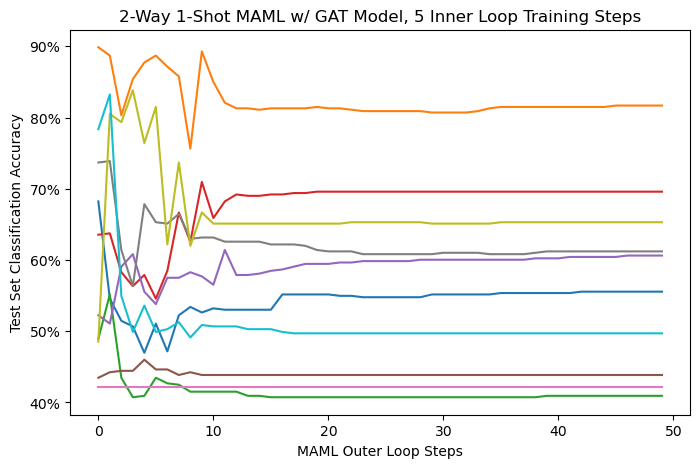

In [ ]:
# Plot evolution of test accuracy over outer loop steps for 10 runs
plt.figure(figsize=(8,5))
for lst in maml_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("MAML Outer Loop Steps")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/2496355488.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.6348148138821125, 12.285, 'Mean: 66.8%')

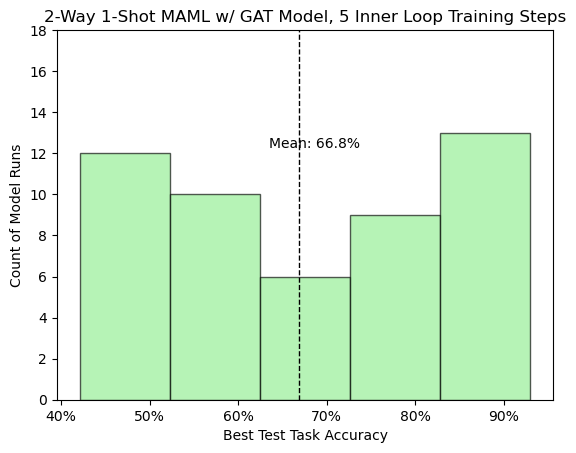

In [ ]:
# Plot histogram of best accuracy achieved with mean
maml_best_test_accs = np.array(maml_best_test_accs)

result = plt.hist(maml_best_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

plt.text(maml_best_test_accs.mean()* 0.95, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_best_test_accs.mean()))

/tmp/ipykernel_31386/3220147070.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.522315790951252, 16.065, 'Mean: 58.0%')

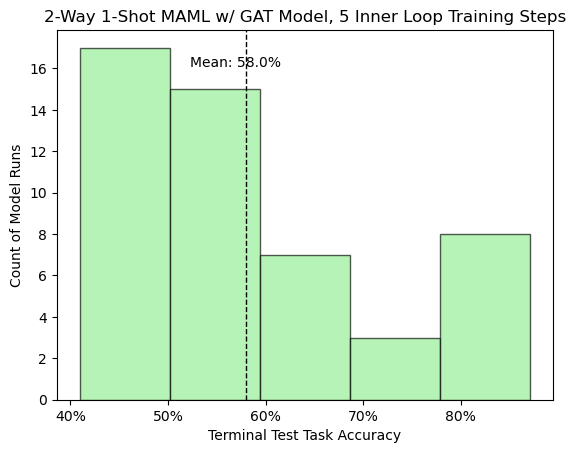

In [ ]:
# Plot histogram of terminal accuracy achieved with mean
maml_terminal_test_accs = np.array(maml_terminal_test_accs)

result = plt.hist(maml_terminal_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0, 18, 2))
plt.text(maml_terminal_test_accs.mean()*0.9, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_terminal_test_accs.mean()))

In [ ]:
print('Best Accs Standard Dev: {}'.format(np.std(maml_best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(maml_terminal_test_accs)))

Best Accs Standard Dev: 0.16902956938307584
Terminal Accs Standard Dev: 0.14022088627266832


### Input hyperparameters, run MAML w/ graph learning for a 2-way, 2-shot task

In [ ]:
# Input parameters here
num_outer_loops = 50
num_inner_steps = 3
num_shots = 2
num_ways = 2
train_classes = (0, 2, 3, 4, 6)

In [ ]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

maml_train_accs = []
maml_test_accs = []
maml_best_test_accs = []
maml_terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                                                  test_classes, train_classes, two_shot_runs[i][0], two_shot_runs[i][1])
    maml_train_accs.append(cur_train_accs)
    maml_test_accs.append(cur_test_accs)
    maml_best_test_accs.append(cur_best_acc)
    maml_terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 2-shot task

/tmp/ipykernel_31386/2672106521.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


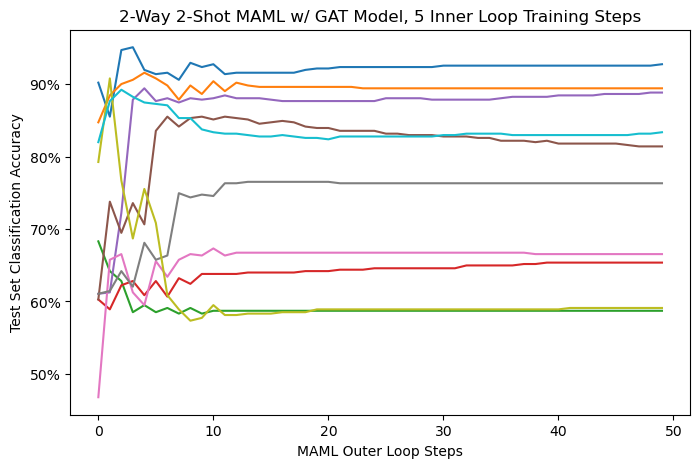

In [ ]:
# Plot evolution of test accuracy over outer loop steps for 10 runs
plt.figure(figsize=(8,5))
for lst in maml_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("MAML Outer Loop Steps")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/2496355488.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.7218512714505195, 17.009999999999998, 'Mean: 76.0%')

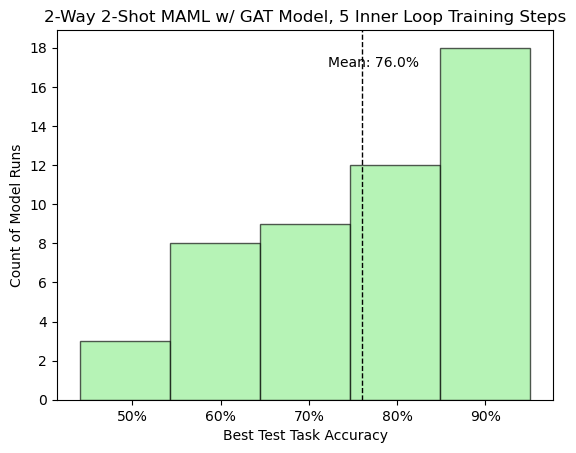

In [ ]:
# Plot histogram of best accuracy achieved with mean
maml_best_test_accs = np.array(maml_best_test_accs)

result = plt.hist(maml_best_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

plt.text(maml_best_test_accs.mean()* 0.95, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_best_test_accs.mean()))

/tmp/ipykernel_31386/964652213.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.5385205464363099, 10.395000000000001, 'Mean: 67.3%')

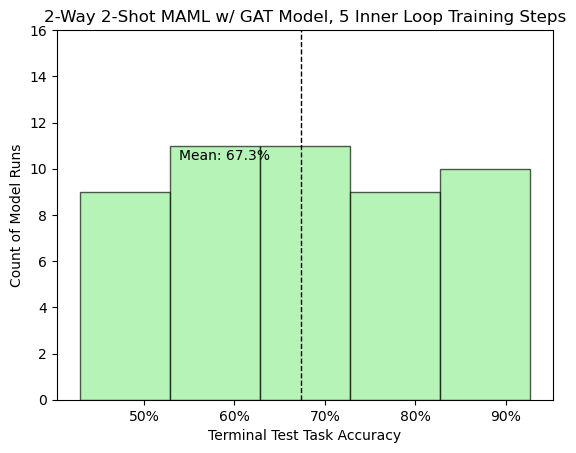

In [ ]:
# Plot histogram of terminal accuracy achieved with mean
maml_terminal_test_accs = np.array(maml_terminal_test_accs)

result = plt.hist(maml_terminal_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0, 18, 2))
plt.text(maml_terminal_test_accs.mean()*0.80, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_terminal_test_accs.mean()))

In [ ]:
print('Best Accs Standard Dev: {}'.format(np.std(maml_best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(maml_terminal_test_accs)))

Best Accs Standard Dev: 0.13411531197257145
Terminal Accs Standard Dev: 0.142271800196552


### Input hyperparameters, run MAML w/ graph learning for a 2-way, 3-shot task

In [ ]:
# Input parameters here
num_outer_loops = 50
num_inner_steps = 3
num_shots = 3
num_ways = 2
train_classes = (0, 2, 3, 4, 6)

In [ ]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

maml_train_accs = []
maml_test_accs = []
maml_best_test_accs = []
maml_terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                                                  test_classes, train_classes, three_shot_runs[i][0], three_shot_runs[i][1])
    maml_train_accs.append(cur_train_accs)
    maml_test_accs.append(cur_test_accs)
    maml_best_test_accs.append(cur_best_acc)
    maml_terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 3-shot task

/tmp/ipykernel_31386/1690427256.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


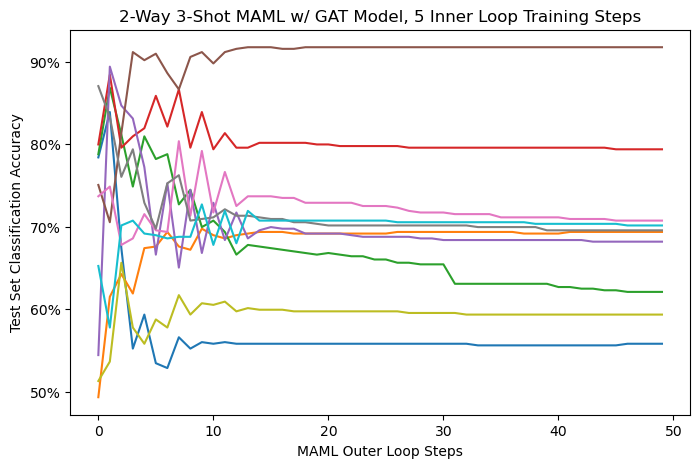

In [ ]:
# Plot evolution of test accuracy over outer loop steps
plt.figure(figsize=(8,5))
for lst in maml_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("MAML Outer Loop Steps")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_31386/195641281.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.7219823178052902, 28.35, 'Mean: 84.9%')

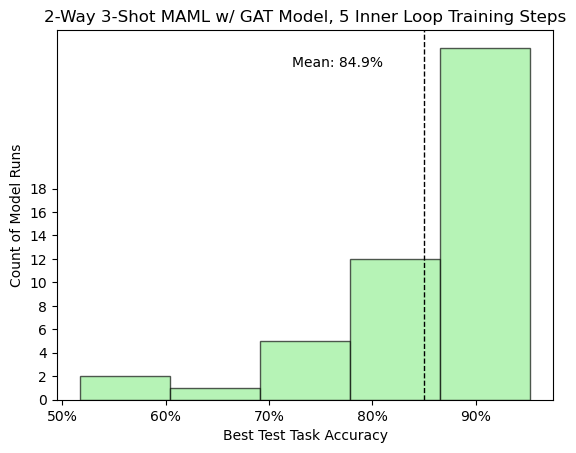

In [ ]:
# Plot histogram of best accuracy achieved with mean
maml_best_test_accs = np.array(maml_best_test_accs)

result = plt.hist(maml_best_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(maml_best_test_accs.mean()*0.85, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_best_test_accs.mean()))

/tmp/ipykernel_31386/959823242.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.5745854616165161, 13.23, 'Mean: 71.8%')

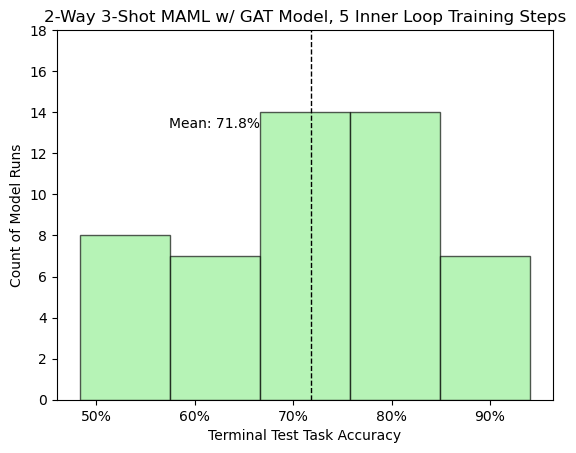

In [ ]:
# Plot histogram of terminal accuracy achieved with mean
maml_terminal_test_accs = np.array(maml_terminal_test_accs)

result = plt.hist(maml_terminal_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ GAT Model, 5 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(maml_terminal_test_accs.mean()*0.80, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_terminal_test_accs.mean()))

In [ ]:
print('Best Accs Standard Dev: {}'.format(np.std(maml_best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(maml_terminal_test_accs)))

Best Accs Standard Dev: 0.09350068776370372
Terminal Accs Standard Dev: 0.12327907962575936
